## EDA
- https://www.indusmic.com/post/want-to-train-your-first-object-detection-model

The most important step for training a model with custom images is to prepare the Tf -records for Tf_records first we have to convert the image into xml file. you may use "LabelImg' tool. Once we have converted the image into xml file we have to convert the image into csv file, we can generate tf-records

In [2]:
import os

os.chdir('../.')

%pwd

'd:\\work\\.ghorai\\certification-courses\\2022-iNeuron-Intelligence\\assignments\\DL_Practical\\assignment6'

In [79]:
# https://www.kaggle.com/code/aledili/transfer-learning-oxford-iiit-pet-classification
# https://www.kaggle.com/code/raivokoot/plot-images-bounding-boxes-visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Get image as numpy array
def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    return img

# Plot numpy array
def plot_image(img):
    plt.imshow(img)
    plt.title(img.shape)

# Plot a grid of examples
def plot_grid(img_files, rows=5, cols=5):
    fig = plt.figure(figsize=(16, 16))
    
    for i, img_file in enumerate(img_files):
        fig.add_subplot(rows,cols,i+1)
        img = load_image(img_file)
        plot_image(img)
        
    plt.show()


In [80]:
IMG_ROOT = "artifacts/data/images/"
ANNOTATION_ROOT = "artifacts/data/annotations/xmls/"

image_files = [os.path.join(IMG_ROOT, fname) for fname in os.listdir(IMG_ROOT) if fname.endswith(".jpg") and not fname.startswith(".")]

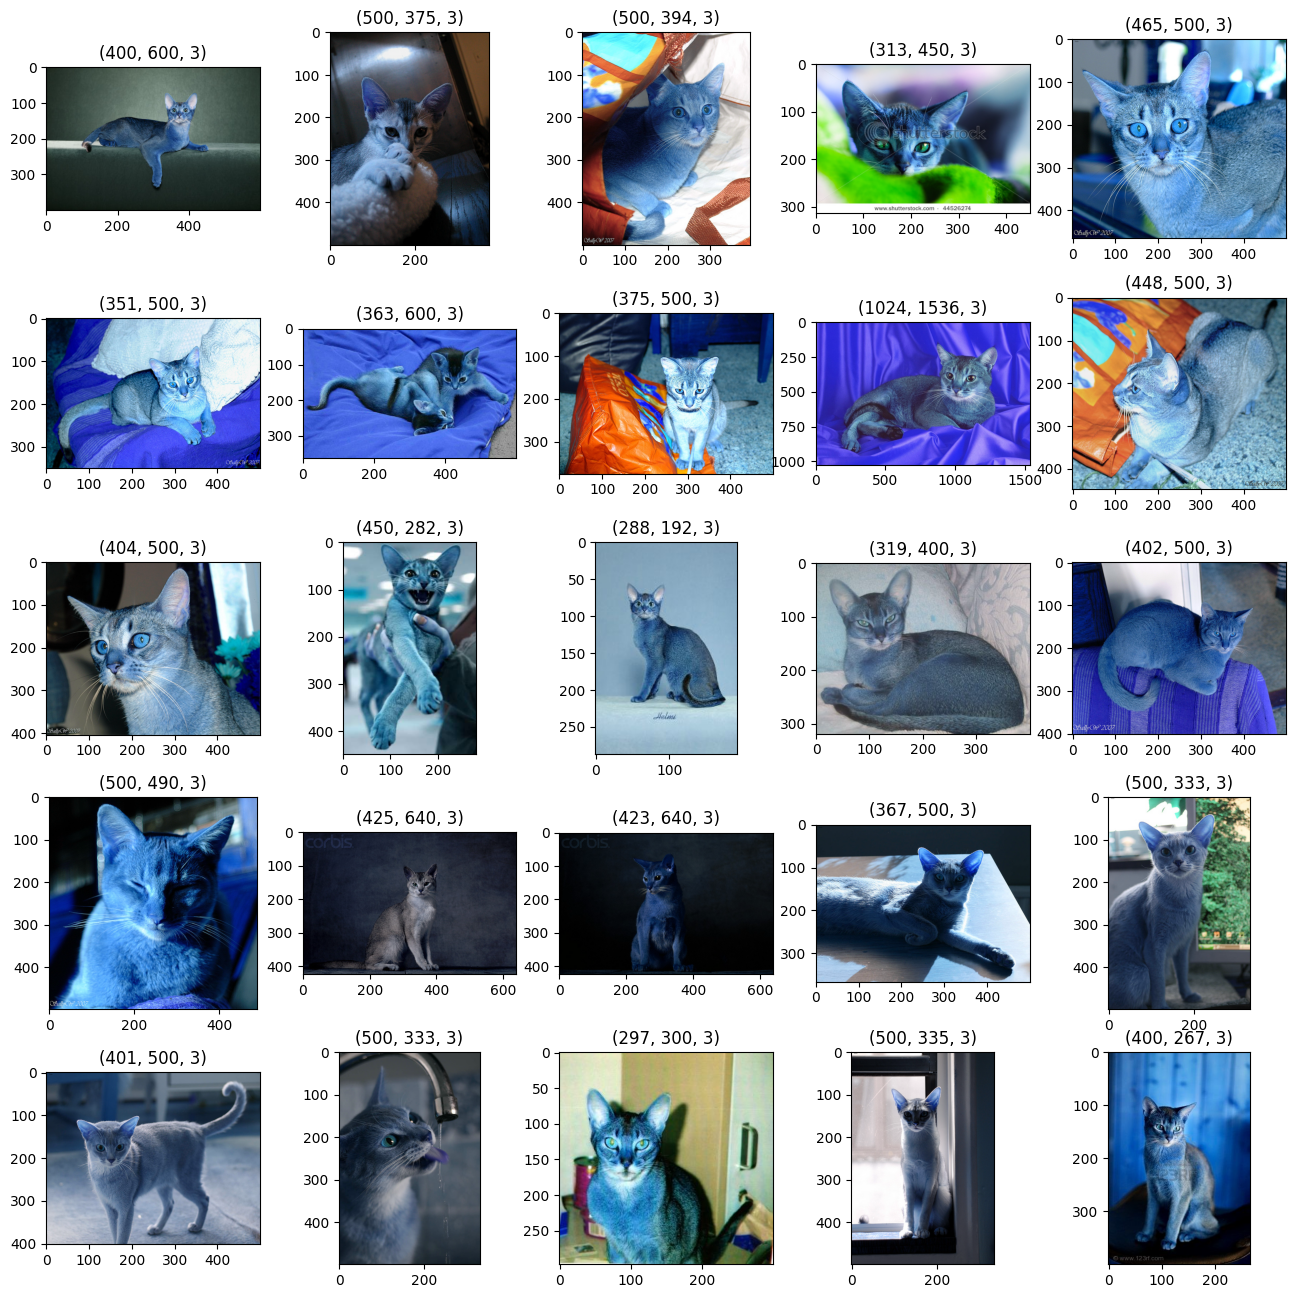

In [81]:
plot_grid(image_files[:25])

In [82]:
import glob
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


In [83]:
xml_df = xml_to_csv(ANNOTATION_ROOT)
xml_df

filename  width  height class  xmin  ymin  xmax  ymax
0              Abyssinian_1.jpg    600     400   cat   333    72   425   158
1             Abyssinian_10.jpg    375     500   cat    72   105   288   291
2            Abyssinian_100.jpg    394     500   cat   151    71   335   267
3            Abyssinian_101.jpg    450     313   cat    54    36   319   235
4            Abyssinian_102.jpg    500     465   cat    23    27   325   320
...                         ...    ...     ...   ...   ...   ...   ...   ...
3682  yorkshire_terrier_186.jpg    500     375   dog   208    32   356   231
3683  yorkshire_terrier_187.jpg    500     334   dog   187    49   317   181
3684  yorkshire_terrier_188.jpg    500     334   dog    94    36   378   263
3685  yorkshire_terrier_189.jpg    500     334   dog   274    84   402   207
3686  yorkshire_terrier_190.jpg    406     500   dog    78    62   305   256

[3687 rows x 8 columns]

In [84]:
# add class id
unique_class = xml_df['class'].unique()

xml_df.loc[:, 'class_id'] = 0

for i, name in enumerate(unique_class):
    xml_df['class_id'][xml_df['class']==name] = i+1

xml_df

C:\Users\USER\AppData\Local\Temp\ipykernel_7212\1199436426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xml_df['class_id'][xml_df['class']==name] = i+1
C:\Users\USER\AppData\Local\Temp\ipykernel_7212\1199436426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xml_df['class_id'][xml_df['class']==name] = i+1


filename  width  height class  xmin  ymin  xmax  ymax  \
0              Abyssinian_1.jpg    600     400   cat   333    72   425   158   
1             Abyssinian_10.jpg    375     500   cat    72   105   288   291   
2            Abyssinian_100.jpg    394     500   cat   151    71   335   267   
3            Abyssinian_101.jpg    450     313   cat    54    36   319   235   
4            Abyssinian_102.jpg    500     465   cat    23    27   325   320   
...                         ...    ...     ...   ...   ...   ...   ...   ...   
3682  yorkshire_terrier_186.jpg    500     375   dog   208    32   356   231   
3683  yorkshire_terrier_187.jpg    500     334   dog   187    49   317   181   
3684  yorkshire_terrier_188.jpg    500     334   dog    94    36   378   263   
3685  yorkshire_terrier_189.jpg    500     334   dog   274    84   402   207   
3686  yorkshire_terrier_190.jpg    406     500   dog    78    62   305   256   

      class_id  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
3682         2  
3683         2  
3684         2  
3685         2  
3686         2  

[3687 rows x 9 columns]

In [85]:
def class_to_color(class_id):
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,100,100)]
    return colors[class_id]

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if annotation.isnull().values.any():
        return
    
    x_min, y_min = int(annotation['xmin']), int(annotation['ymin'])
    x_max, y_max = int(annotation['xmax']), int(annotation['ymax'])
    
    class_id = int(annotation['class_id'])
    color = class_to_color(class_id)
    
    cv2.rectangle(img, (x_min,y_min), (x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, name, all_annotations):
    annotations = all_annotations[all_annotations['filename'] == name]
    for index, row in annotations.iterrows():
        draw_bounding_box(img, row)

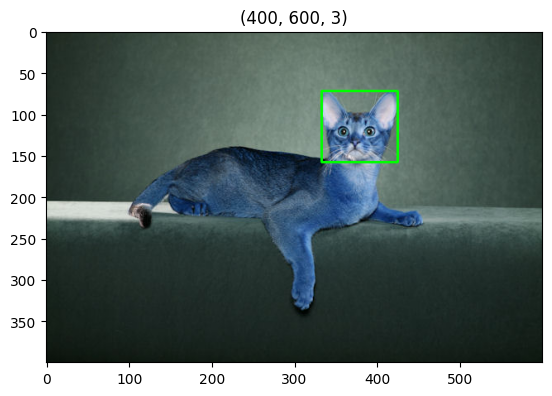

In [86]:
# Plot a single sample with all its bounding boxes
name = 'Abyssinian_1.jpg'
image_path = os.path.join(IMG_ROOT, name)
img = load_image(image_path)
annotate_image(img, name, xml_df)
plot_image(img)

In [87]:
# Plot a grid of xray images, each with all its bounding boxes
def plot_annotated_grid(img_names, img_root, all_annotations, rows=5, cols=5):
    fig = plt.figure(figsize=(16,16))
    
    for i, row in img_names.iterrows():
        name = row['filename']
        fig.add_subplot(rows,cols,i+1)
        image_path = os.path.join(img_root, name)
        img = load_image(image_path)
        annotate_image(img, name, all_annotations)
        plot_image(img)
        
    plt.show()

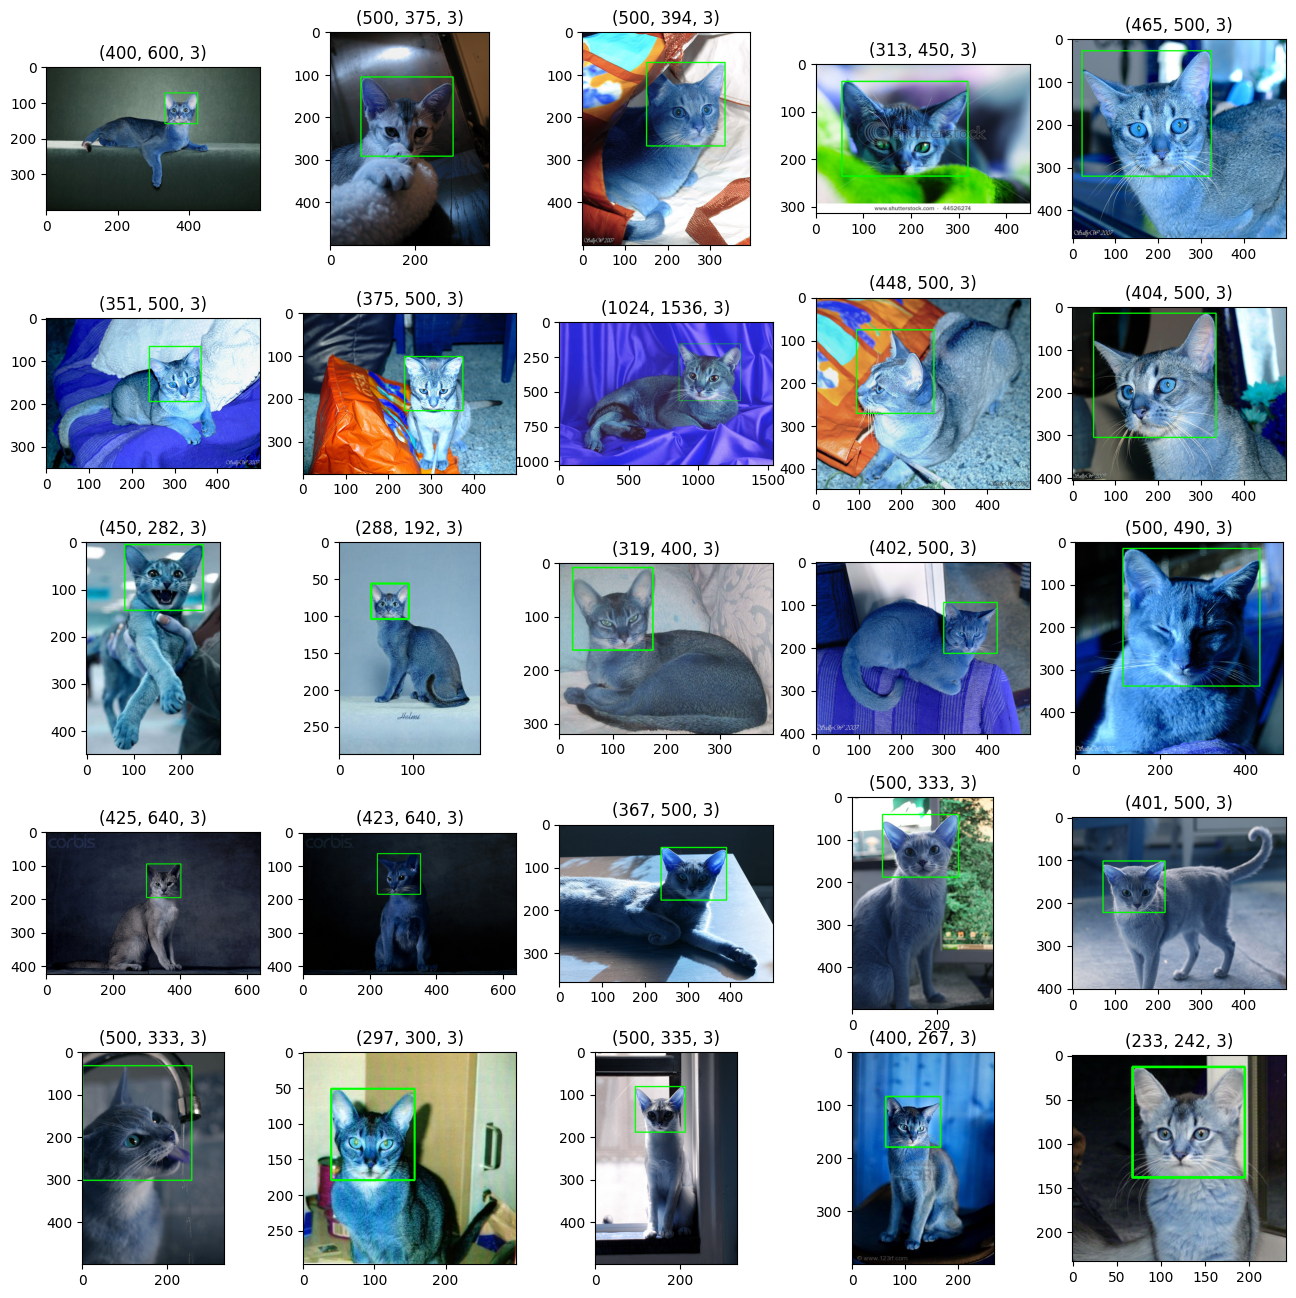

In [88]:
# Plot 25 xray images with their bounding boxes
plot_annotated_grid(xml_df[:25], IMG_ROOT, xml_df, rows=5, cols=5)

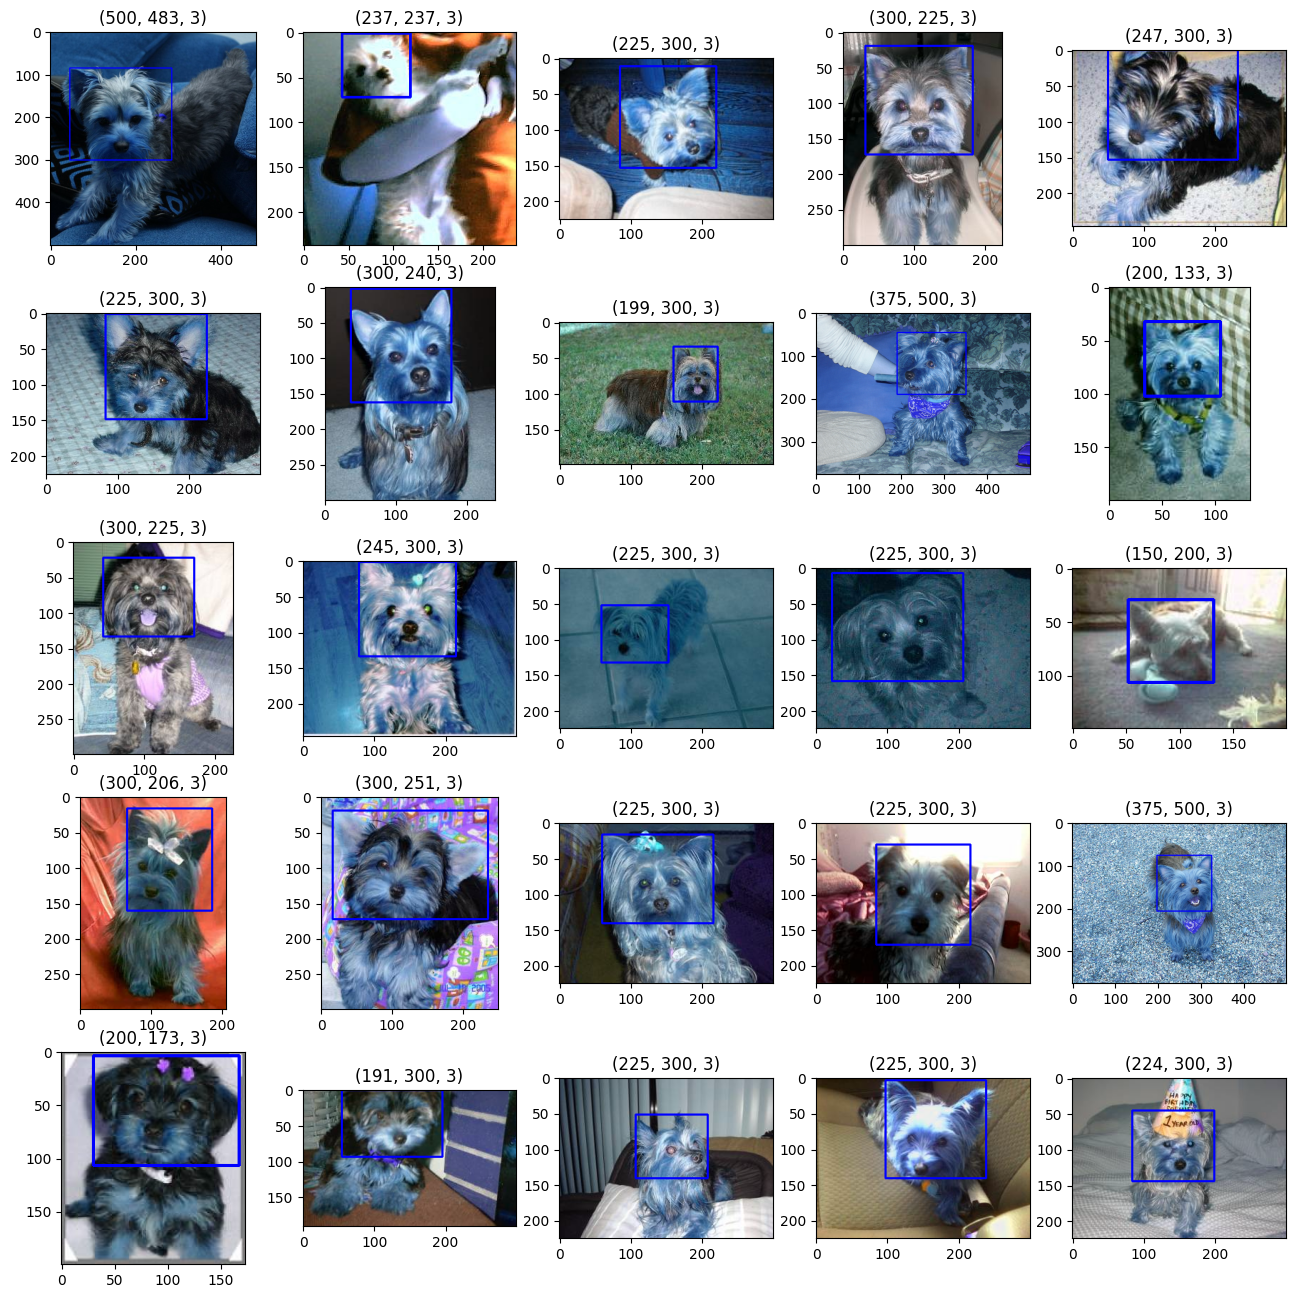

In [89]:
df = xml_df[(xml_df.index > 3600) & (xml_df.index <= 3625)]
df.reset_index(drop=True, inplace=True)

# name = 'yorkshire_terrier_112.jpg'
# image_path = os.path.join(IMG_ROOT, name)
# img = load_image(image_path)
# annotate_image(img, name, df)
# plot_image(img)

plot_annotated_grid(df, IMG_ROOT, xml_df, rows=5, cols=5)